# DATA 200 – Applied Statistical Analysis
## Week 6: Statistical Modeling (Continued) – Finalized Insights
**Team Fintech** | Saugat Ojha · Rakesh Kumar Sah · Naitik Shrestha

---
## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve, ConfusionMatrixDisplay, precision_score,
    recall_score, f1_score
)
from matplotlib.patches import Patch
import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style='whitegrid', font_scale=1.05)
plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.figsize'] = (12, 5)

BLUE = '#2E86AB'
RED  = '#E84855'

---
## 2. Load and Prepare Data

In [2]:
df = pd.read_csv(r'C:\Users\admin\Desktop\project-team-x\bank.csv')
df['deposit_bin'] = (df['deposit'] == 'yes').astype(int)

df_encoded = df.copy()
le = LabelEncoder()
cat_cols = ['job', 'marital', 'education', 'default', 'housing',
            'loan', 'contact', 'month', 'poutcome']

for col in cat_cols:
    df_encoded[col] = le.fit_transform(df_encoded[col])

df_encoded.drop(columns=['deposit'], inplace=True)

features = [c for c in df_encoded.columns if c != 'deposit_bin']
X = df_encoded[features]
y = df_encoded['deposit_bin']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lr_rfe = LogisticRegression(max_iter=1000, random_state=42)
rfe = RFE(estimator=lr_rfe, n_features_to_select=8)
rfe.fit(X_scaled, y)

selected_features = [f for f, s in zip(features, rfe.support_) if s]

X_selected = df_encoded[selected_features]
X_scaled_selected = scaler.fit_transform(X_selected)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_selected, y, test_size=0.2, random_state=42, stratify=y
)

model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

y_pred       = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print(f'Data loaded. Train: {X_train.shape[0]} | Test: {X_test.shape[0]}')
print(f'Selected features: {selected_features}')

Data loaded. Train: 8929 | Test: 2233
Selected features: ['education', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous']


---
## 3. Full Model Performance Summary

In [3]:
acc       = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall    = recall_score(y_test, y_pred)
f1        = f1_score(y_test, y_pred)
roc_auc   = roc_auc_score(y_test, y_pred_proba)

metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC'],
    'Value':  [round(acc, 4), round(precision, 4), round(recall, 4), round(f1, 4), round(roc_auc, 4)],
    'Percentage': [f'{acc*100:.2f}%', f'{precision*100:.2f}%', f'{recall*100:.2f}%',
                   f'{f1*100:.2f}%', f'{roc_auc*100:.2f}%']
})

print('Full Model Performance Metrics:')
print(metrics_df.to_string(index=False))

Full Model Performance Metrics:
   Metric  Value Percentage
 Accuracy 0.7922     79.22%
Precision 0.7912     79.12%
   Recall 0.7628     76.28%
 F1 Score 0.7767     77.67%
  ROC-AUC 0.8701     87.01%


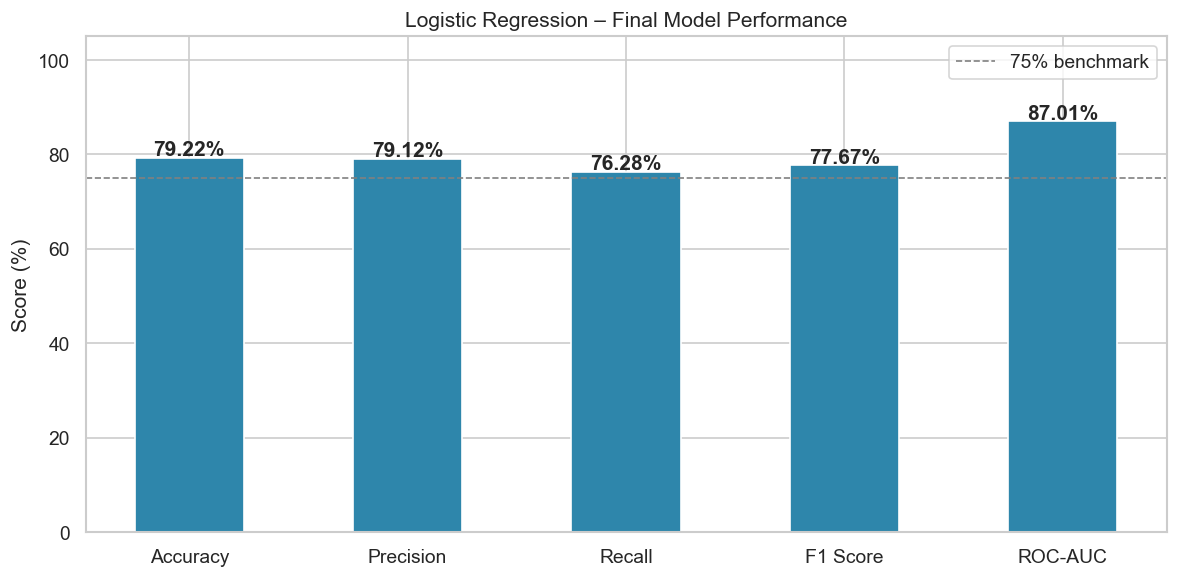

In [4]:
fig, ax = plt.subplots(figsize=(10, 5))
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC']
metric_vals  = [acc, precision, recall, f1, roc_auc]
colors = [BLUE if v >= 0.75 else RED for v in metric_vals]
bars = ax.bar(metric_names, [v * 100 for v in metric_vals], color=colors, edgecolor='white', width=0.5)
for bar, val in zip(bars, metric_vals):
    ax.text(bar.get_x() + bar.get_width()/2, val*100 + 0.5,
            f'{val*100:.2f}%', ha='center', fontweight='bold')
ax.axhline(75, color='gray', linestyle='--', linewidth=1, label='75% benchmark')
ax.set_ylabel('Score (%)')
ax.set_ylim(0, 105)
ax.set_title('Logistic Regression – Final Model Performance')
ax.legend()
plt.tight_layout()
plt.show()

---
## 4. Confusion Matrix and ROC Curve

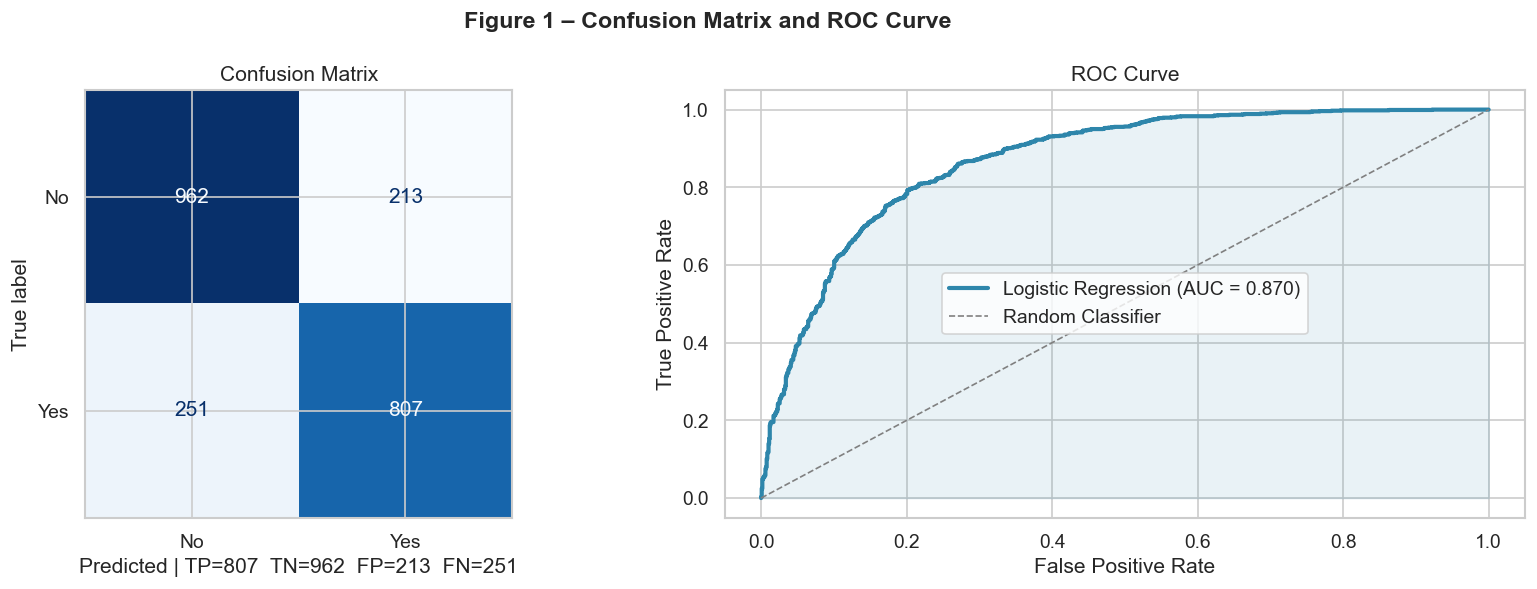

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Figure 1 – Confusion Matrix and ROC Curve', fontsize=14, fontweight='bold')

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(ax=axes[0], colorbar=False, cmap='Blues')
axes[0].set_title('Confusion Matrix')

tn, fp, fn, tp = cm.ravel()
axes[0].set_xlabel(f'Predicted | TP={tp}  TN={tn}  FP={fp}  FN={fn}')

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
axes[1].plot(fpr, tpr, color=BLUE, linewidth=2.5, label=f'Logistic Regression (AUC = {roc_auc:.3f})')
axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=1, label='Random Classifier')
axes[1].fill_between(fpr, tpr, alpha=0.1, color=BLUE)
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend()

plt.tight_layout()
plt.show()

---
## 5. Cross-Validation – Final Results

In [6]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_accuracy  = cross_val_score(model, X_scaled_selected, y, cv=cv, scoring='accuracy')
cv_precision = cross_val_score(model, X_scaled_selected, y, cv=cv, scoring='precision')
cv_recall    = cross_val_score(model, X_scaled_selected, y, cv=cv, scoring='recall')
cv_f1        = cross_val_score(model, X_scaled_selected, y, cv=cv, scoring='f1')
cv_auc       = cross_val_score(model, X_scaled_selected, y, cv=cv, scoring='roc_auc')

cv_summary = pd.DataFrame({
    'Metric':    ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC'],
    'Mean':      [cv_accuracy.mean(), cv_precision.mean(), cv_recall.mean(), cv_f1.mean(), cv_auc.mean()],
    'Std Dev':   [cv_accuracy.std(), cv_precision.std(), cv_recall.std(), cv_f1.std(), cv_auc.std()]
}).round(4)

print('5-Fold Cross-Validation Summary:')
print(cv_summary.to_string(index=False))

5-Fold Cross-Validation Summary:
   Metric   Mean  Std Dev
 Accuracy 0.7902   0.0086
Precision 0.7905   0.0068
   Recall 0.7580   0.0161
 F1 Score 0.7739   0.0106
  ROC-AUC 0.8657   0.0062


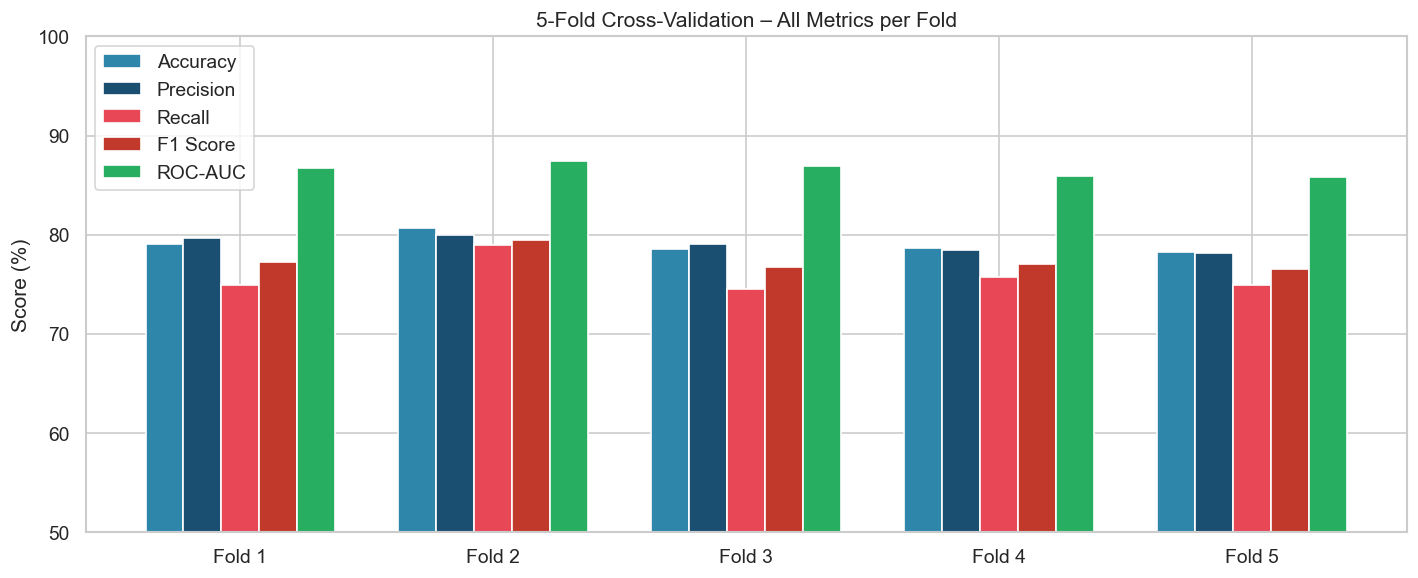

In [7]:
fig, ax = plt.subplots(figsize=(12, 5))
x = np.arange(5)
width = 0.15

ax.bar(x - 2*width, cv_accuracy  * 100, width, label='Accuracy',  color='#2E86AB', edgecolor='white')
ax.bar(x - width,   cv_precision * 100, width, label='Precision', color='#1B4F72', edgecolor='white')
ax.bar(x,           cv_recall    * 100, width, label='Recall',    color='#E84855', edgecolor='white')
ax.bar(x + width,   cv_f1        * 100, width, label='F1 Score',  color='#C0392B', edgecolor='white')
ax.bar(x + 2*width, cv_auc       * 100, width, label='ROC-AUC',   color='#27AE60', edgecolor='white')

ax.set_xticks(x)
ax.set_xticklabels([f'Fold {i+1}' for i in range(5)])
ax.set_ylabel('Score (%)')
ax.set_ylim(50, 100)
ax.set_title('5-Fold Cross-Validation – All Metrics per Fold')
ax.legend()
plt.tight_layout()
plt.show()

---
## 6. Threshold Analysis

In [8]:
thresholds_range = np.arange(0.1, 0.9, 0.05)
threshold_results = []

for t in thresholds_range:
    y_pred_t = (y_pred_proba >= t).astype(int)
    threshold_results.append({
        'threshold': round(t, 2),
        'accuracy':  round(accuracy_score(y_test, y_pred_t), 4),
        'precision': round(precision_score(y_test, y_pred_t, zero_division=0), 4),
        'recall':    round(recall_score(y_test, y_pred_t, zero_division=0), 4),
        'f1':        round(f1_score(y_test, y_pred_t, zero_division=0), 4)
    })

threshold_df = pd.DataFrame(threshold_results)
print(threshold_df.to_string(index=False))

 threshold  accuracy  precision  recall     f1
      0.10    0.5983     0.5414  0.9953 0.7013
      0.15    0.6511     0.5771  0.9868 0.7283
      0.20    0.7017     0.6171  0.9764 0.7562
      0.25    0.7295     0.6459  0.9499 0.7689
      0.30    0.7595     0.6810  0.9263 0.7849
      0.35    0.7734     0.7075  0.8894 0.7881
      0.40    0.7868     0.7413  0.8450 0.7898
      0.45    0.7936     0.7672  0.8100 0.7880
      0.50    0.7922     0.7912  0.7628 0.7767
      0.55    0.7837     0.8095  0.7108 0.7569
      0.60    0.7716     0.8293  0.6522 0.7302
      0.65    0.7515     0.8440  0.5832 0.6898
      0.70    0.7210     0.8469  0.5019 0.6303
      0.75    0.7013     0.8600  0.4414 0.5834
      0.80    0.6807     0.8791  0.3781 0.5288
      0.85    0.6538     0.8904  0.3072 0.4568


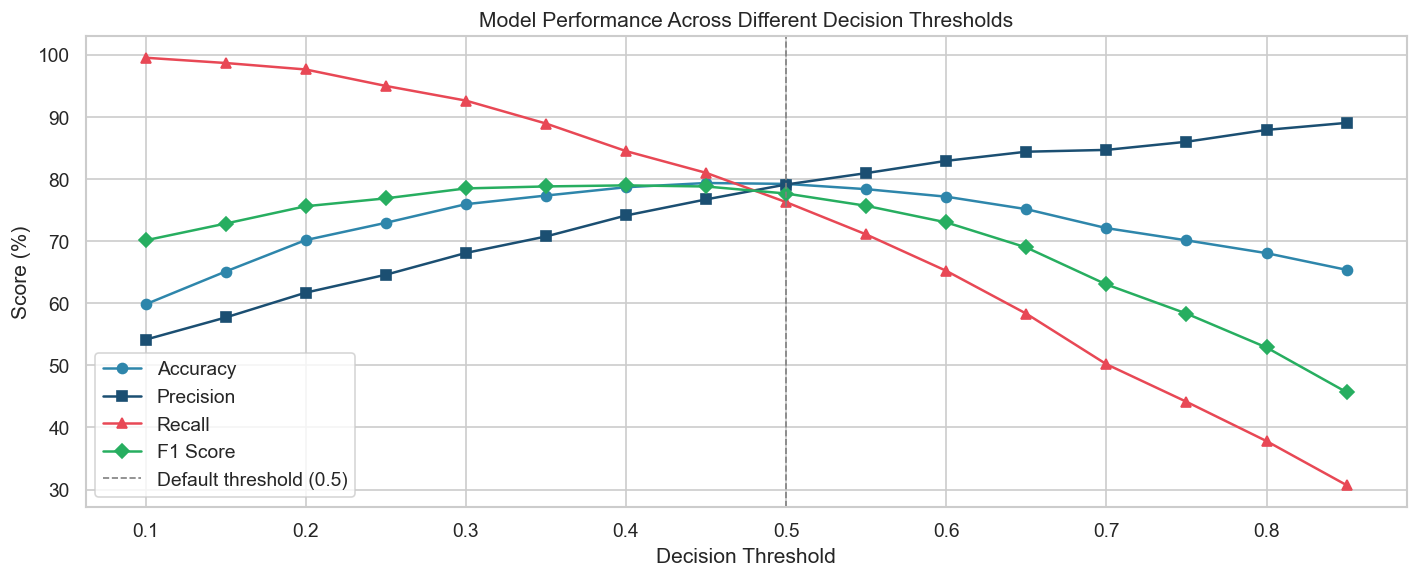

In [9]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(threshold_df['threshold'], threshold_df['accuracy']  * 100, marker='o', label='Accuracy',  color='#2E86AB')
ax.plot(threshold_df['threshold'], threshold_df['precision'] * 100, marker='s', label='Precision', color='#1B4F72')
ax.plot(threshold_df['threshold'], threshold_df['recall']    * 100, marker='^', label='Recall',    color='#E84855')
ax.plot(threshold_df['threshold'], threshold_df['f1']        * 100, marker='D', label='F1 Score',  color='#27AE60')
ax.axvline(0.5, color='gray', linestyle='--', linewidth=1, label='Default threshold (0.5)')
ax.set_xlabel('Decision Threshold')
ax.set_ylabel('Score (%)')
ax.set_title('Model Performance Across Different Decision Thresholds')
ax.legend()
plt.tight_layout()
plt.show()

---
## 7. Feature Importance – Final Interpretation

In [10]:
coef_df = pd.DataFrame({
    'feature':     selected_features,
    'coefficient': model.coef_[0].round(4),
    'odds_ratio':  np.exp(model.coef_[0]).round(4)
}).sort_values('odds_ratio', ascending=False)

print('Final Feature Interpretation:')
print(coef_df.to_string(index=False))

Final Feature Interpretation:
  feature  coefficient  odds_ratio
 duration       1.7230      5.6011
 previous       0.2416      1.2733
    pdays       0.2262      1.2539
education       0.1781      1.1950
     loan      -0.2823      0.7540
 campaign      -0.3920      0.6757
  contact      -0.5031      0.6046
  housing      -0.5294      0.5890


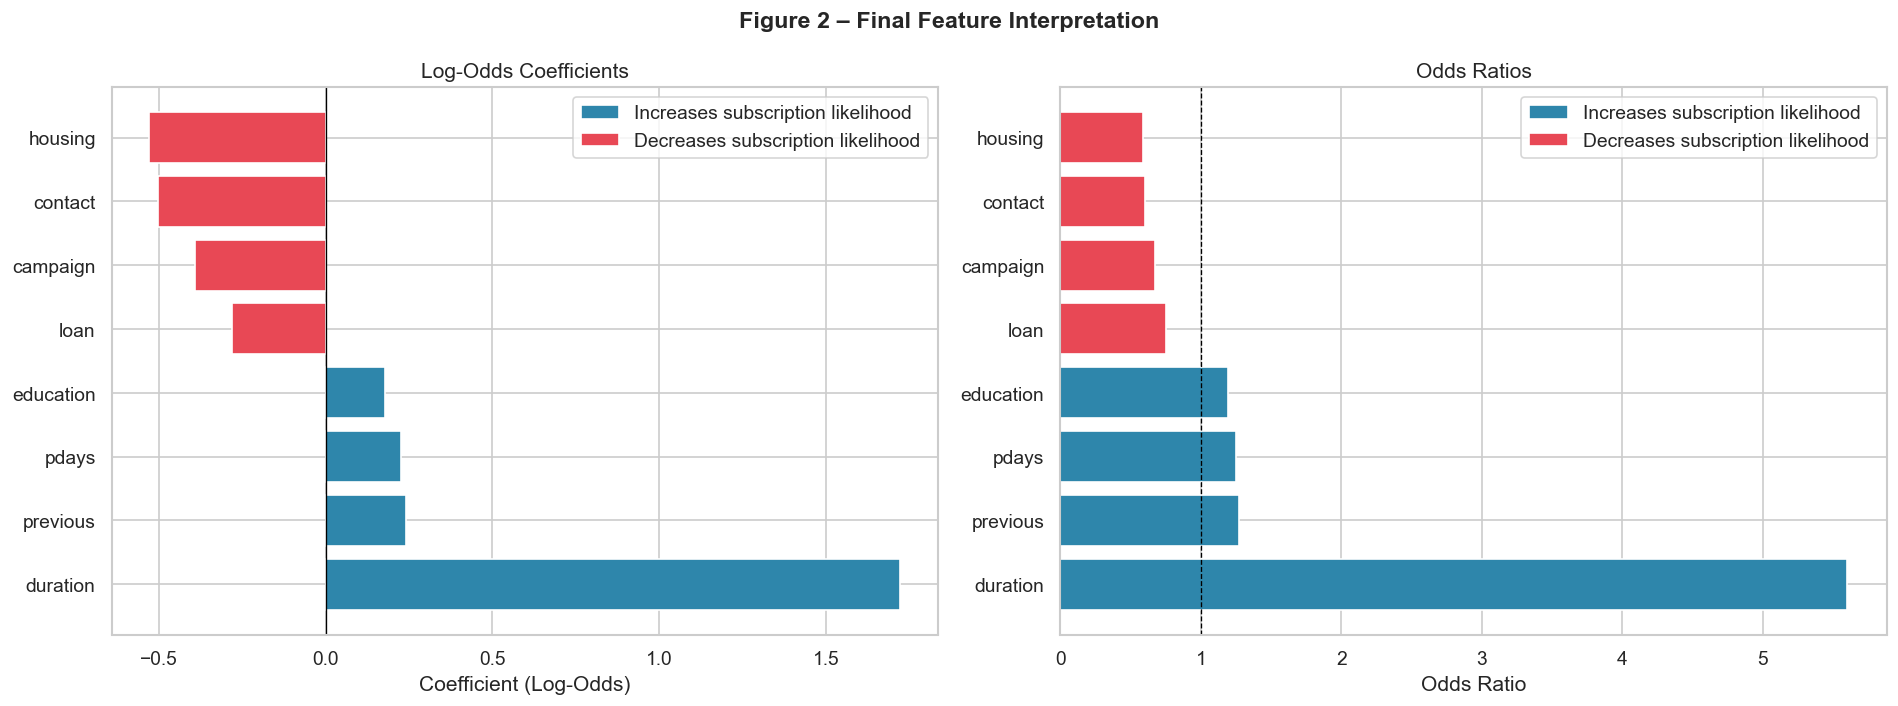

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Figure 2 – Final Feature Interpretation', fontsize=14, fontweight='bold')

colors = [BLUE if c > 0 else RED for c in coef_df['coefficient']]

axes[0].barh(coef_df['feature'], coef_df['coefficient'], color=colors, edgecolor='white')
axes[0].axvline(0, color='black', linewidth=0.8)
axes[0].set_xlabel('Coefficient (Log-Odds)')
axes[0].set_title('Log-Odds Coefficients')
legend_elements = [
    Patch(facecolor=BLUE, label='Increases subscription likelihood'),
    Patch(facecolor=RED,  label='Decreases subscription likelihood')
]
axes[0].legend(handles=legend_elements)

axes[1].barh(coef_df['feature'], coef_df['odds_ratio'], color=colors, edgecolor='white')
axes[1].axvline(1, color='black', linewidth=0.8, linestyle='--')
axes[1].set_xlabel('Odds Ratio')
axes[1].set_title('Odds Ratios')
axes[1].legend(handles=legend_elements)

plt.tight_layout()
plt.show()

---
## 8. Prediction Probability Distribution

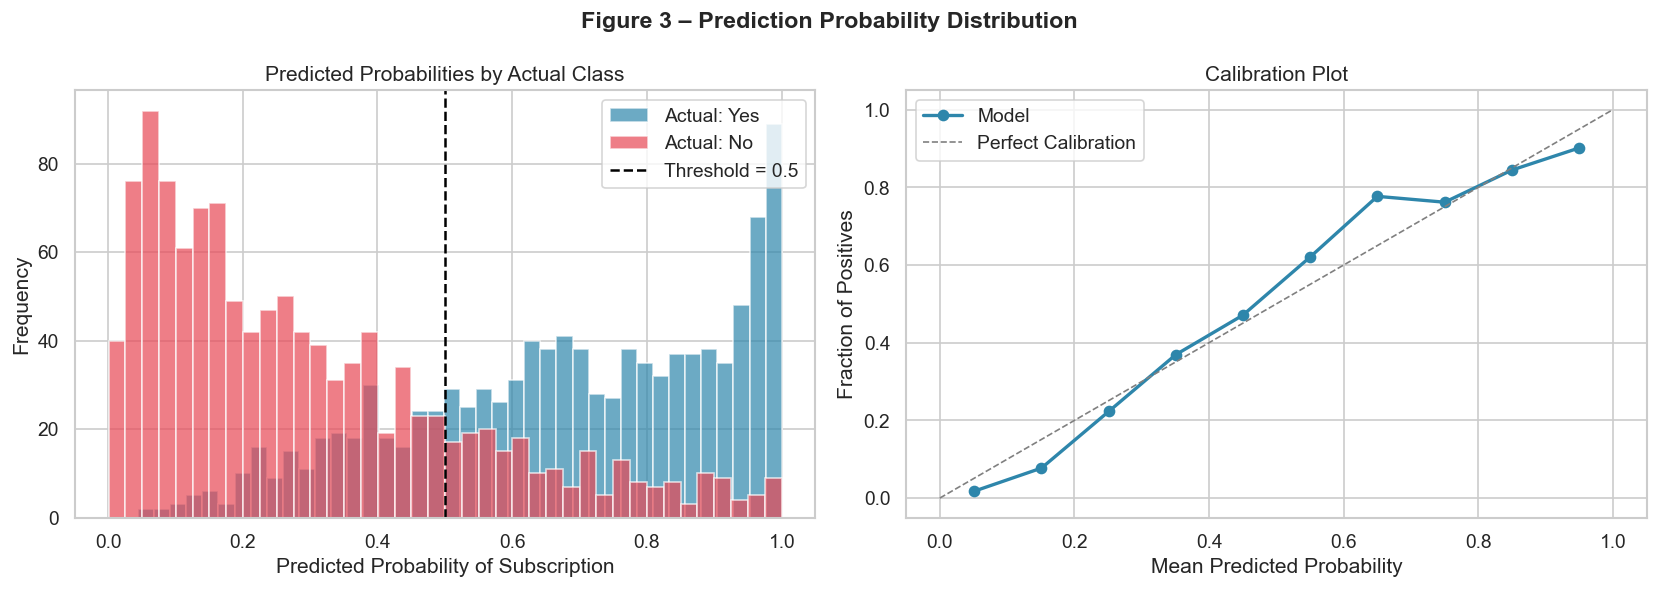

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Figure 3 – Prediction Probability Distribution', fontsize=14, fontweight='bold')

axes[0].hist(y_pred_proba[y_test == 1], bins=40, color=BLUE, alpha=0.7, edgecolor='white', label='Actual: Yes')
axes[0].hist(y_pred_proba[y_test == 0], bins=40, color=RED,  alpha=0.7, edgecolor='white', label='Actual: No')
axes[0].axvline(0.5, color='black', linestyle='--', linewidth=1.5, label='Threshold = 0.5')
axes[0].set_xlabel('Predicted Probability of Subscription')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Predicted Probabilities by Actual Class')
axes[0].legend()

prob_df = pd.DataFrame({'prob': y_pred_proba, 'actual': y_test.values})
prob_df['bucket'] = pd.cut(prob_df['prob'], bins=10)
calibration = prob_df.groupby('bucket', observed=True)['actual'].mean()
bucket_mids = [interval.mid for interval in calibration.index]

axes[1].plot(bucket_mids, calibration.values, marker='o', color=BLUE, linewidth=2, label='Model')
axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=1, label='Perfect Calibration')
axes[1].set_xlabel('Mean Predicted Probability')
axes[1].set_ylabel('Fraction of Positives')
axes[1].set_title('Calibration Plot')
axes[1].legend()

plt.tight_layout()
plt.show()

---
## 9. Key Findings and Insights

In [13]:
insights_df = pd.DataFrame({
    'Finding': [
        'Call Duration (duration)',
        'Previous Outcome (poutcome)',
        'Account Balance (balance)',
        'Campaign Contacts (campaign)',
        'Contact Type (contact)',
        'Month of Contact (month)',
        'Model Generalization',
        'Dataset Balance'
    ],
    'Insight': [
        'Strongest predictor — longer calls strongly associated with subscription',
        'Clients with successful prior campaigns are significantly more likely to subscribe',
        'Higher account balance clients show greater tendency to subscribe',
        'More contacts in current campaign negatively affects subscription likelihood',
        'Cellular contact significantly outperforms telephone and unknown',
        'March, September, October, December show highest subscription rates',
        f'CV Accuracy {cv_accuracy.mean()*100:.2f}% — model generalizes well across folds',
        'Near-balanced target (47.4% yes) — no resampling required'
    ],
    'Action': [
        'Prioritize longer, quality conversations over quantity',
        'Re-target clients with successful prior campaign history first',
        'Segment campaigns to focus on higher-balance client profiles',
        'Limit calls to 1-3 per client to avoid diminishing returns',
        'Prioritize cellular contact channel in future campaigns',
        'Schedule campaigns to peak in high-conversion months',
        'Model is stable and suitable for deployment',
        'Training data is representative — no class imbalance issues'
    ]
})

insights_df

,Finding,Insight,Action
0,Call Duration (duration),Strongest predictor — longer calls strongly as...,"Prioritize longer, quality conversations over ..."
1,Previous Outcome (poutcome),Clients with successful prior campaigns are si...,Re-target clients with successful prior campai...
2,Account Balance (balance),Higher account balance clients show greater te...,Segment campaigns to focus on higher-balance c...
3,Campaign Contacts (campaign),More contacts in current campaign negatively a...,Limit calls to 1-3 per client to avoid diminis...
4,Contact Type (contact),Cellular contact significantly outperforms tel...,Prioritize cellular contact channel in future ...
5,Month of Contact (month),"March, September, October, December show highe...",Schedule campaigns to peak in high-conversion ...
6,Model Generalization,CV Accuracy 79.02% — model generalizes well ac...,Model is stable and suitable for deployment
7,Dataset Balance,Near-balanced target (47.4% yes) — no resampli...,Training data is representative — no class imb...


---
## 10. Report Draft – Results Section

In [14]:
print(f"""
RESULTS AND DISCUSSION – REPORT DRAFT
=============================================================

Dataset
The Bank Marketing Dataset contains 11,162 records and 16
features covering client demographics, campaign history, and
economic indicators. The target variable (deposit) is binary
and near-balanced at 47.4% positive class.

Feature Selection
Three methods were applied: Point Biserial Correlation,
Chi-Square testing, and Recursive Feature Elimination (RFE).
The final 8 selected features were: {selected_features}.

Hypothesis Testing
All four hypotheses were statistically significant (p < 0.05):
  H1 – Duration positively associated with subscription (T-test)
  H2 – Previous outcome significantly affects subscription (Chi-Square)
  H3 – Balance positively associated with subscription (T-test)
  H4 – Campaign contacts negatively associated with subscription (T-test)

Model Performance
  Accuracy  : {acc*100:.2f}%
  Precision : {precision*100:.2f}%
  Recall    : {recall*100:.2f}%
  F1 Score  : {f1*100:.2f}%
  ROC-AUC   : {roc_auc:.4f}

Cross-Validation (5-Fold)
  Mean Accuracy : {cv_accuracy.mean()*100:.2f}% +/- {cv_accuracy.std()*100:.2f}%
  Mean ROC-AUC  : {cv_auc.mean():.4f} +/- {cv_auc.std():.4f}

The model demonstrates stable performance across all folds,
confirming that Logistic Regression is appropriate for this
binary classification task and generalizes well to unseen data.

Key Recommendation
Banks should prioritize clients with longer call histories,
prior subscription success, higher balances, and cellular
contact to maximize campaign conversion rates.
=============================================================
""")


RESULTS AND DISCUSSION – REPORT DRAFT

Dataset
The Bank Marketing Dataset contains 11,162 records and 16
features covering client demographics, campaign history, and
economic indicators. The target variable (deposit) is binary
and near-balanced at 47.4% positive class.

Feature Selection
Three methods were applied: Point Biserial Correlation,
Chi-Square testing, and Recursive Feature Elimination (RFE).
The final 8 selected features were: ['education', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous'].

Hypothesis Testing
All four hypotheses were statistically significant (p < 0.05):
  H1 – Duration positively associated with subscription (T-test)
  H2 – Previous outcome significantly affects subscription (Chi-Square)
  H3 – Balance positively associated with subscription (T-test)
  H4 – Campaign contacts negatively associated with subscription (T-test)

Model Performance
  Accuracy  : 79.22%
  Precision : 79.12%
  Recall    : 76.28%
  F1 Score  : 77.67%
  ROC-

---
## 11. Week 6 Summary

In [15]:
print(f"""
Week 6 Summary
=============================================================
Model              : Logistic Regression (finalized)
Selected Features  : {selected_features}

Final Metrics:
  Accuracy          : {acc*100:.2f}%
  Precision         : {precision*100:.2f}%
  Recall            : {recall*100:.2f}%
  F1 Score          : {f1*100:.2f}%
  ROC-AUC           : {roc_auc:.4f}
  CV Accuracy       : {cv_accuracy.mean()*100:.2f}% +/- {cv_accuracy.std()*100:.2f}%

Insights Finalized : 8
Report Draft       : Complete

Next Steps (Week 7):
  - Build Python application using Streamlit or Tkinter
  - Application to accept client inputs and predict subscription
  - Integrate trained Logistic Regression model into the app
=============================================================
""")


Week 6 Summary
Model              : Logistic Regression (finalized)
Selected Features  : ['education', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous']

Final Metrics:
  Accuracy          : 79.22%
  Precision         : 79.12%
  Recall            : 76.28%
  F1 Score          : 77.67%
  ROC-AUC           : 0.8701
  CV Accuracy       : 79.02% +/- 0.86%

Insights Finalized : 8
Report Draft       : Complete

Next Steps (Week 7):
  - Build Python application using Streamlit or Tkinter
  - Application to accept client inputs and predict subscription
  - Integrate trained Logistic Regression model into the app

